- detect segments
- smooth (splne) segment headings
- cluster headings
- combine clusters based on some tolerance (same tolerance as segmentation)
- assign trajs to new groups in these clusters

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
import geopandas
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import movingpandas as mpd
from fiona.crs import from_epsg
from glob import glob
import numpy as np
import pickle
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def iterative_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                j+=1 #Start a new trajectory label
        start_value = row[criterion] #Update comparison value. This method is more robust to changes in curvature
        #that may not represent a new trajectory
        trajectory_id.append(j)
        k +=1
    gdf['traj_id'] = trajectory_id
    return gdf


def direction_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
            k+=1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                start_angle = row[criterion] #only change starting angle if we're starting a new trajectory
                j+=1 #Start a new trajectory label
         #Update 
        trajectory_id.append(j)
    gdf['traj_id'] = trajectory_id
    return gdf

# Read in a dataset and detect segments

In [ ]:
survey = pickle.load(open('datasets/survey.pkl','rb'))
geo_df = survey.df
geo_df = geo_df[~geo_df.latitude.isnull()]
geo_df['dist'] = geo_df.distance(geo_df.shift(-1))
geo_df['speed'] = geo_df.dist/geo_df.index.to_series().diff().dt.total_seconds()
def bearing(gdf):
    from numpy import sin, cos, arctan2
    #Take difference between i and i+1 rows, we get a deltalon column
    deltalon = gdf['longitude'].diff(1).shift(-1)
    #Move i+1 to ith row, now we have our lat2 column
    lat2 = gdf.shift(-1)['latitude'] 
    #Keep rows the same, this is our lat1 column
    lat1 = gdf['latitude']

    x0 = sin(deltalon)*cos(lat2)
    x1 = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(deltalon)
    bearing = arctan2(x0, x1)
    return bearing
geo_df['bearing'] = np.degrees(bearing(geo_df))
dataset = iterative_segmentation(geo_df, 'speed', .00001)

In [111]:
traj_collection = mpd.TrajectoryCollection(dataset, 'traj_id') # assemble into a mpd collection to utilize their traj calculations
trajSummary = pd.DataFrame({'id':[traj.id for traj in traj_collection.trajectories], 'length':[traj.get_length() for traj in traj_collection.trajectories],'heading': [traj.get_direction() for traj in traj_collection.trajectories]})

Estimated number of clusters: 5


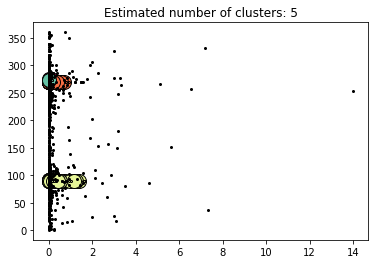

In [112]:
# Use DBSCAN to determine clusters based on, in this case, traj length and heading
X = trajSummary[['length','heading']]
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

#just a plot to see the clusters and noise
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.length, xy.heading, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.length, xy.heading, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [120]:
trajSummary['cluster'] = labels
matchingTrajectories = mpd.TrajectoryCollection(dataset[dataset.traj_id.isin(trajSummary[trajSummary.cluster!=-1].id.values)], 'traj_id')

In [121]:
matchingTrajectories.hvplot(tiles='EsriImagery')

:Overlay
   .Tiles.I       :Tiles   [x,y]
   .Path.I        :Path   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Path.XXVI     :Path   [Longitude,Latitude]
   .Path.XXVII    :Path   [Longitude,Latitude]
   .Path.XXVIII   :Path   [Longitude,Latitude]
   .Path.XXIX     :Path   [Longitude,Latitude]
   .Path.XXX      :Path   [Longitude,Latitude]
   .Path.XXXI     :Path   [Longitude,Latitude]
   .Path.XXXII    :Path   [Longitude,Latitude]
   .Path.XXXIII   :Path   [Longitude,Latitude]
   .Path.XXXIV    :Path   [Longitude,Latitude]
   .Path.XXXV     :Path   [Longitude,Latitude]
   .Path.XXXVI    :Path   [Longitude,Latitude]
   .Path.XXXVII   :Path   [Longitude,Latitude]
   .Path.XXXVIII  :Path   [Longitude,Latitude]
   .Path.XXXIX    :Path   [Longitude,Latitude]
   .Path.XL       :Path   [Longitude,Latitude]
   .Path.XLI      :Path   [Longitude,Latitude]
   .Path.XLII     :Path   [Longitude,Latitude]
   .Path.XLIII    :Path   [Longitude,Latitude]
   .Path.XLIV     :Path   [Longitude,Latitude]
   .Path.XLV      :Path   [Longitude,Latitude]
   .Path.XLVI     :Path   [Longitude,Latitude]
   .Path.XLVII    :Path   [Longitude,Latitude]
   .Path.XLVIII   :Path   [Longitude,Latitude]
   .Path.XLIX     :Path   [Longitude,Latitude]
   .Path.L        :Path   [Longitude,Latitude]
   .Path.LI       :Path   [Longitude,Latitude]
   .Path.LII      :Path   [Longitude,Latitude]
   .Path.LIII     :Path   [Longitude,Latitude]
   .Path.LIV      :Path   [Longitude,Latitude]
   .Path.LV       :Path   [Longitude,Latitude]
   .Path.LVI      :Path   [Longitude,Latitude]
   .Path.LVII     :Path   [Longitude,Latitude]
   .Path.LVIII    :Path   [Longitude,Latitude]
   .Path.LIX      :Path   [Longitude,Latitude]
   .Path.LX       :Path   [Longitude,Latitude]
   .Path.LXI      :Path   [Longitude,Latitude]
   .Path.LXII     :Path   [Longitude,Latitude]
   .Path.LXIII    :Path   [Longitude,Latitude]
   .Path.LXIV     :Path   [Longitude,Latitude]
   .Path.LXV      :Path   [Longitude,Latitude]
   .Path.LXVI     :Path   [Longitude,Latitude]
   .Path.LXVII    :Path   [Longitude,Latitude]
   .Path.LXVIII   :Path   [Longitude,Latitude]
   .Path.LXIX     :Path   [Longitude,Latitude]
   .Path.LXX      :Path   [Longitude,Latitude]
   .Path.LXXI     :Path   [Longitude,Latitude]
   .Path.LXXII    :Path   [Longitude,Latitude]
   .Path.LXXIII   :Path   [Longitude,Latitude]
   .Path.LXXIV    :Path   [Longitude,Latitude]
   .Path.LXXV     :Path   [Longitude,Latitude]
   .Path.LXXVI    :Path   [Longitude,Latitude]
   .Path.LXXVII   :Path   [Longitude,Latitude]
   .Path.LXXVIII  :Path   [Longitude,Latitude]
   .Path.LXXIX    :Path   [Longitude,Latitude]
   .Path.LXXX     :Path   [Longitude,Latitude]
   .Path.LXXXI    :Path   [Longitude,Latitude]
   .Path.LXXXII   :Path   [Longitude,Latitude]
   .Path.LXXXIII  :Path   [Longitude,Latitude]
   .Path.LXXXIV   :Path   [Longitude,Latitude]
   .Path.L